## Clustering

Clustering is an unsupervised learning approach used to group similar data points together based on their inherent characteristics. The goal is to identify patterns and structures in the dataset without prior knowledge of the labels. In this project, we hope to use clustering to discover meaningful subgroups within the patient population, which could help in understanding differences in treatment responses or outcomes, and potentially reveal patient phenotypes that benefit from specific interventions.


Table of contents
- 0. Prepare the Jupyter Notebook
- 1. Standardization or Normalization
- 2. Kmeans clustering

### 0. Preparing the Jupyter Notebook

To begin, we load the necessary libraries and import the prepared dataset. We will use **`patient_data_onehot_imputed`** as it already includes all preprocessing steps required for machine learning, except for **normalization or standardization**. This ensures we have a consistent and clean dataset ready for further analysis.


In [1]:
# Set the flag for different approaches
exclude_no_ttm = False # If you change this, check the optimal number of clusters and the results...

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [3]:
# Loading the dataset
with open('data/patient_data_onehot_imputed.pkl', 'rb') as file:
    processed_data = pickle.load(file)

processed_data.head()

,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,284,53.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,286,85.0,7.0,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,296,48.0,18.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,299,45.0,18.0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,303,51.0,24.0,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False


In [4]:
# Loading the original dataset for later comparison of clusters
with open('data/patient_data.pkl', 'rb') as file:
    original_data = pickle.load(file)
    
original_data.head()

,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,284,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0
1,286,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0
2,296,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0
3,299,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0
4,303,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0


### 1. Standardization or Normalization

Next, we determine whether **standardization** or **normalization** is appropriate for our dataset to ensure consistent feature scaling. To make an informed decision, we first visualize the distribution of the numerical features. Based on these distributions, we then apply the selected scaling technique to align the data for better performance in machine learning models.


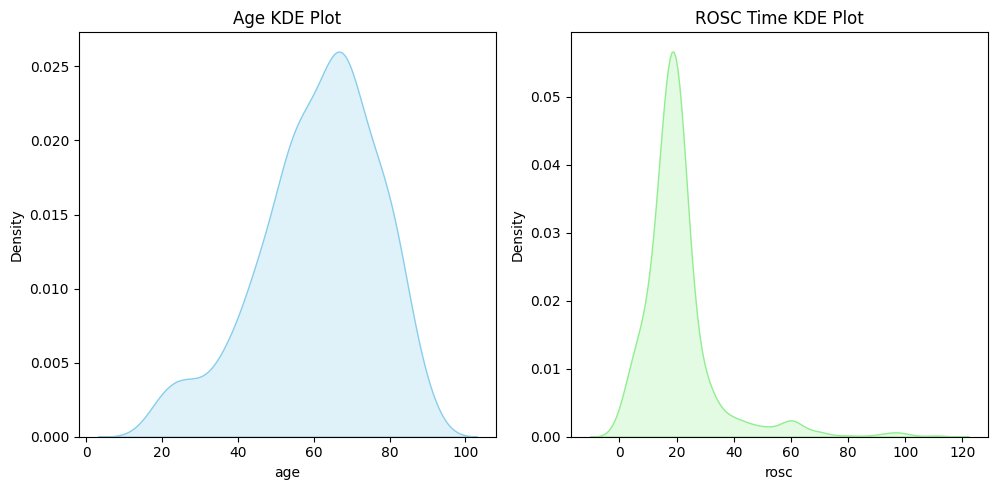

In [5]:
# Plotting count plot for CPC instead of KDE plot
plt.figure(figsize=(15, 5))

# Age KDE Plot
plt.subplot(1, 3, 1)
sns.kdeplot(processed_data['age'], fill=True, color='skyblue')
plt.title('Age KDE Plot')

# ROSC KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(processed_data['rosc'], fill=True, color='lightgreen')
plt.title('ROSC Time KDE Plot')

plt.tight_layout()
plt.show()


In [6]:
# Display all unique ROSC times from the dataset
unique_rosc_times = processed_data['rosc'].unique()
unique_rosc_times_sorted = np.sort(unique_rosc_times)

# Print the unique ROSC times in sorted order
print(unique_rosc_times_sorted)

[  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
  13.   14.   15.   16.   17.   18.   19.   20.   21.   21.5  22.   24.
  25.   26.   27.   29.   30.   32.   33.   34.   35.   36.   37.   38.
  40.   42.   44.   45.   47.   50.   52.   54.   55.   60.   62.   63.
  67.   70.   80.   90.   95.   96.   98.  100.  111. ]


**Analysis**: The **age** distribution is approximately **normal**, with a slight skew towards lower values and a peak just below **70**. The **ROSC** distribution also appears roughly **normal**, but contains several significant **outliers** that need to be addressed before proceeding with further analysis. Eventhough **ROSC** appears to have negative values, it actually does not.

In [7]:
# Apply Box-Cox transformation to ROSC time
rosc_transformed_boxcox, lambda_value = boxcox(processed_data['rosc'])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_boxcox'] = rosc_transformed_boxcox

In [8]:
# Apply Yeo-Johnson transformation to ROSC time
power_transformer = PowerTransformer(method='yeo-johnson')
rosc_transformed = power_transformer.fit_transform(processed_data[['rosc']])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_yeojohnson'] = rosc_transformed

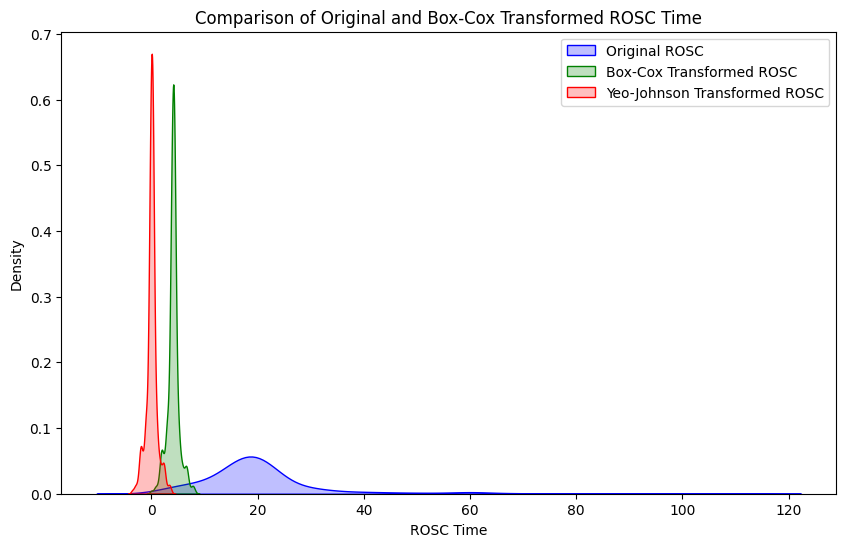

In [9]:
# Plotting original ROSC and Box-Cox transformed ROSC to compare
plt.figure(figsize=(10, 6))

# Original ROSC KDE Plot
sns.kdeplot(processed_data['rosc'], fill=True, color='blue', label='Original ROSC')

# Box-Cox Transformed ROSC KDE Plot
sns.kdeplot(processed_data['rosc_boxcox'], fill=True, color='green', label='Box-Cox Transformed ROSC')

# Apply Yeo-Johnson transformation to ROSC time
sns.kdeplot(processed_data['rosc_yeojohnson'], fill=True, color='red', label='Yeo-Johnson Transformed ROSC')

plt.title('Comparison of Original and Box-Cox Transformed ROSC Time')
plt.xlabel('ROSC Time')
plt.ylabel('Density')
plt.legend()
plt.show()


**Analysis**: Both the **Box-Cox** and **Yeo-Johnson** transformations effectively narrow the distribution, reducing the impact of high outliers. However, the **Box-Cox transformation** retains a slightly broader spread compared to **Yeo-Johnson**, making it preferable for preserving more variability in the data. Therefore, we will proceed with the **Box-Cox transformation**.

#### Standardization
After applying the **Box-Cox transformation** to handle skewness and reduce the influence of outliers, we proceed with **standardization**. Standardization rescales the features so that they have a mean of **0** and a standard deviation of **1**, which is particularly useful for models that assume normally distributed input data or are sensitive to feature scales.

By standardizing the data, we ensure that all features are on a comparable scale, which helps improve model performance and convergence during training.


In [10]:
# Instantiate the scaler
scaler = StandardScaler()

# Columns to standardize
columns_to_standardize = ['age', 'rosc', 'rosc_boxcox', 'rosc_yeojohnson']

# Apply standardization
processed_data[columns_to_standardize] = scaler.fit_transform(processed_data[columns_to_standardize])

# Display the standardized DataFrame
processed_data.head()

,Patient,age,rosc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,...,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc_boxcox,rosc_yeojohnson
0,284,-0.522787,-0.215362,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
1,286,1.525272,-1.023892,False,False,False,False,True,True,False,...,False,False,False,False,True,True,False,False,-1.510616,-1.537350
2,296,-0.842797,-0.215362,True,False,False,False,False,False,True,...,True,False,False,True,False,False,True,False,-0.039577,-0.034742
3,299,-1.034802,-0.215362,True,False,False,False,False,False,True,...,True,False,True,False,False,False,True,False,-0.039577,-0.034742
4,303,-0.650791,0.225655,False,False,True,False,False,False,True,...,True,False,True,False,False,False,True,False,0.471501,0.482048


#### Selecting Data for the Machine Learning Component from the Original DataFrame

We are now selecting the relevant features, including the transformed `rosc` data, from the original DataFrame. This subset will be placed into a new DataFrame, `machine_learning_df`, for clearer separation and easier manipulation during model training. We can experiment with the included features as needed to optimize model performance.

Based on the findings in **02_Feature_Importance**, we concluded that hospital identifiers are not relevant for our model. This aligns with the medical perspective, as our focus should remain on patient-related features. For now, we will retain the other features and proceed with the Box-Cox transformed `rosc`.

In [11]:
# Selecting the desired columns
selected_columns = ['Patient', 'age', 'sex_Female', 'sex_Male', 'ohca_True', 'ohca_False', 'ohca_Unknown', 
                    'ttm_33.0', 'ttm_36.0', 'ttm_No TTM', 
                    'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 
                    'rosc', 'rosc_boxcox','rosc_yeojohnson']

# Creating a new DataFrame with only the selected columns
machine_learning_df = processed_data[selected_columns]

if exclude_no_ttm:
    # Try to exclude No_TTM as we are interested in TTM
    machine_learning_df = machine_learning_df[machine_learning_df['ttm_No TTM'] == 0]
    machine_learning_df = machine_learning_df.drop(columns=['ttm_No TTM'])
    original_data = original_data[original_data['ttm'].isin([33.0, 36.0])]


# Set up the df dictionary to compare the different scalers
dataframes_clustering = {
    "rosc": machine_learning_df.drop(columns=['rosc_boxcox', 'rosc_yeojohnson', 'Patient']),
    "rosc_boxcox": machine_learning_df.drop(columns=['rosc', 'rosc_yeojohnson', 'Patient']),
    "rosc_yeojohnson": machine_learning_df.drop(columns=['rosc', 'rosc_boxcox', 'Patient'])
}

### 2. KMeans Clustering
**KMeans Clustering** is an unsupervised machine learning algorithm that groups data points into a specified number of clusters (k) based on feature similarity. The algorithm assigns each data point to the nearest cluster centroid, iteratively updating the centroids until the optimal clustering configuration is reached.

In this project, we use KMeans clustering to uncover potential patterns or natural groupings within the data. By analyzing these clusters, we hope to gain insights into distinct patient subgroups that may share similar characteristics, which could be valuable for tailoring treatment approaches or identifying risk profiles.

#### 2.1 Silhouette Scores

We use **Silhouette Scores** to determine the optimal number of clusters for the `machine_learning_patient_data`. This method evaluates how well each data point fits within its assigned cluster compared to other clusters, providing a measure of clustering quality. Higher silhouette scores indicate that data points are well-matched within their clusters and distinct from others, which helps us assess the "purity" of each cluster.

The algorithm iterates through various cluster counts, calculating the silhouette score for each, allowing us to identify the number of clusters that best separates the data into meaningful groups.

**Usually, there should be only about 10-15% clusters compared to the data size.** Choosing too large a number of clusters can cause overfitting and may even capture noise rather than meaningful patterns. Additionally, for clinical practice, selecting a low number of clusters that remain interpretable is ideal, which typically means fewer than 20 clusters. However, we will run from 2 to 50 clusters and try to focus on a local maximum under 20 clusters.

Calculating silhouette scores for rosc...


c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


For rosc, n_clusters = 2, the average silhouette score is: 0.17355579053100129
For rosc, n_clusters = 3, the average silhouette score is: 0.19625272004547897
For rosc, n_clusters = 4, the average silhouette score is: 0.20560254085748964
For rosc, n_clusters = 5, the average silhouette score is: 0.20997123297852452
For rosc, n_clusters = 6, the average silhouette score is: 0.20730381092131855
For rosc, n_clusters = 7, the average silhouette score is: 0.233695488796556
For rosc, n_clusters = 8, the average silhouette score is: 0.21996030312116763
For rosc, n_clusters = 9, the average silhouette score is: 0.22113506641556088
For rosc, n_clusters = 10, the average silhouette score is: 0.2281479927739232
For rosc, n_clusters = 11, the average silhouette score is: 0.23638152260515044
For rosc, n_clusters = 12, the average silhouette score is: 0.23274923824819851
For rosc, n_clusters = 13, the average silhouette score is: 0.25525732860825484
For rosc, n_clusters = 14, the average silhouette s

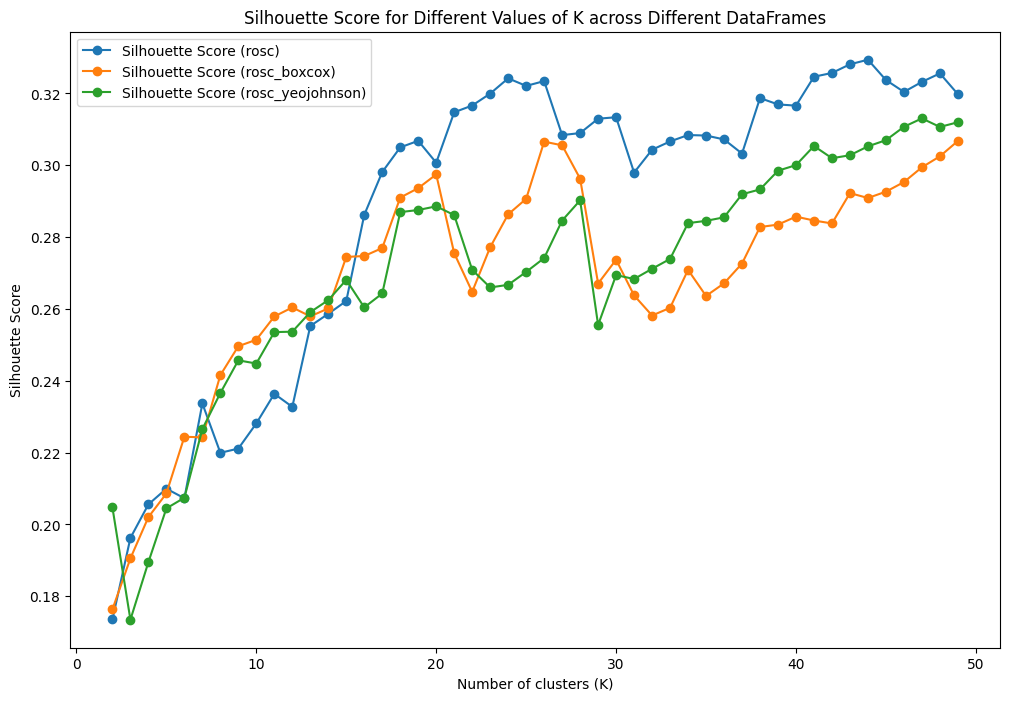

In [12]:
# Decide the number of k
# Initialize lists to hold values for plotting
silhouette_scores_all = {key: [] for key in dataframes_clustering.keys()}
k_values = range(2, 50)

# Iterate over each dataframe and calculate silhouette scores
for name, data in dataframes_clustering.items():
    print(f"Calculating silhouette scores for {name}...")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=2023)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores_all[name].append(silhouette_avg)
        print(f"For {name}, n_clusters = {k}, the average silhouette score is: {silhouette_avg}")

# Plot silhouette scores for each dataframe
plt.figure(figsize=(12, 8))
for name, scores in silhouette_scores_all.items():
    plt.plot(k_values, scores, marker='o', label=f'Silhouette Score ({name})')

plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of K across Different DataFrames')
plt.legend()
plt.show()

### Evaluation of Silhouette Scores for KMeans Clustering

The silhouette scores for different values of \( K \) (number of clusters) and various scaling approaches provide insights into the optimal clustering structure:

- **Standardized rosc** shows the highest silhouette scores for smaller clusters, peaking until about \( K = 20 \).
- **Rosc_yeojohnson** reaches its highest silhouette score of approximately **0.32** at \( K = 32 \), indicating a potential for more nuanced clustering with this transformation.

For scenarios favoring a lower number of clusters, we focus on **standardized rosc** scores for interpretability.

---

#### Key Silhouette Scores by Cluster Count

- **For \( K = 6 \)**, the average silhouette score is **0.2275**
- **For \( K = 7 \)**, the average silhouette score is **0.2494**
- **For \( K = 8 \)**, the average silhouette score is **0.2735**
- **For \( K = 9 \)**, the average silhouette score is **0.2744**
- **For \( K = 10 \)**, the average silhouette score is **0.2651**
  
- **For \( K = 17 \)**, the average silhouette score is **0.2889**
- **For \( K = 18 \)**, the average silhouette score is **0.2968**
- **For \( K = 19 \)**, the average silhouette score is **0.2928**

---

#### Analysis

The silhouette scores indicate that:

- **Considering lower numbers of clusters**, there is a steady increase in silhouette scores up to \( K = 9 \), where the score reaches **0.2744**. After a slight decrease, the silhouette score climbs to **0.2968** at \( K = 18 \).

For simplicity and interpretability, we choose \( K = 9 \) as the optimal number of clusters. Although \( K = 18 \) achieves a slightly higher score, \( K = 9 \) provides a balance between score and interpretability, facilitating clearer insights into cluster characteristics.


#### Saving Data for Classification Attempts

We are saving `machine_learning_df` to use consistently across classification attempts, ensuring that the same data preparation is applied throughout the model evaluation process.


In [13]:
# Select the data for clustering
data_for_clustering = machine_learning_df.drop(columns=['rosc_boxcox', 'rosc_yeojohnson'])
data_for_clustering

,Patient,age,sex_Female,sex_Male,ohca_True,ohca_False,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,284,-0.522787,False,True,True,False,False,True,False,False,False,True,False,-0.215362
1,286,1.525272,True,False,False,True,False,False,False,True,True,False,False,-1.023892
2,296,-0.842797,False,True,True,False,False,False,True,False,False,True,False,-0.215362
3,299,-1.034802,False,True,True,False,False,True,False,False,False,True,False,-0.215362
4,303,-0.650791,False,True,True,False,False,True,False,False,False,True,False,0.225655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,1016,1.653275,False,True,True,False,False,True,False,False,True,False,False,-1.023892
603,1017,-2.250837,False,True,True,False,False,False,False,True,True,False,False,2.283731
604,1018,0.117231,False,True,True,False,False,False,True,False,False,True,False,0.041898
605,1019,0.693248,False,True,True,False,False,False,True,False,False,True,False,-0.215362


In [14]:
# Save the DataFrame to a Pickle file
with open('data/machine_learning_patient_data.pkl', 'wb') as f:
    pickle.dump(data_for_clustering, f)

# Confirmation message
print("DataFrame has been saved to 'data/machine_learning_patient_data.pkl'")

DataFrame has been saved to 'data/machine_learning_patient_data.pkl'


### Perform the Clustering

In [15]:
# Drop patient number before clustering
data_for_clustering = data_for_clustering.drop('Patient', axis=1)

# Perform K-means clustering on the standardized data
n_clusters = 14 #9
kmeans = KMeans(n_clusters=n_clusters, random_state=2023)
kmeans.fit(data_for_clustering)

# Add cluster labels from KMeans to the original data as 'kmeans_cluster'
original_data['kmeans_cluster'] = kmeans.labels_

# Display the first few rows of processed_data with the cluster labels
original_data.head()


,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing,kmeans_cluster
0,284,A,53.0,Male,NaN,True,True,33.0,Good,1,1,0,13
1,286,F,85.0,Female,7.0,False,False,No TTM,Good,1,0,0,5
2,296,A,48.0,Male,NaN,True,True,36.0,Good,1,1,0,13
3,299,A,45.0,Male,NaN,True,True,33.0,Good,1,1,0,13
4,303,D,51.0,Male,24.0,True,True,33.0,Good,1,0,0,13


In [16]:
# Count the number of data points in each cluster
cluster_counts = original_data['kmeans_cluster'].value_counts()

# Display the counts for each cluster
print(cluster_counts)

kmeans_cluster
1     95
0     92
13    85
3     40
7     38
4     37
9     35
12    35
11    33
10    28
6     27
8     27
5     23
2     12
Name: count, dtype: int64


#### 2.2 Cluster Analysis

We will now analyze the clusters by examining the distribution of features within each cluster. This analysis will provide insights into the characteristics that define each group.


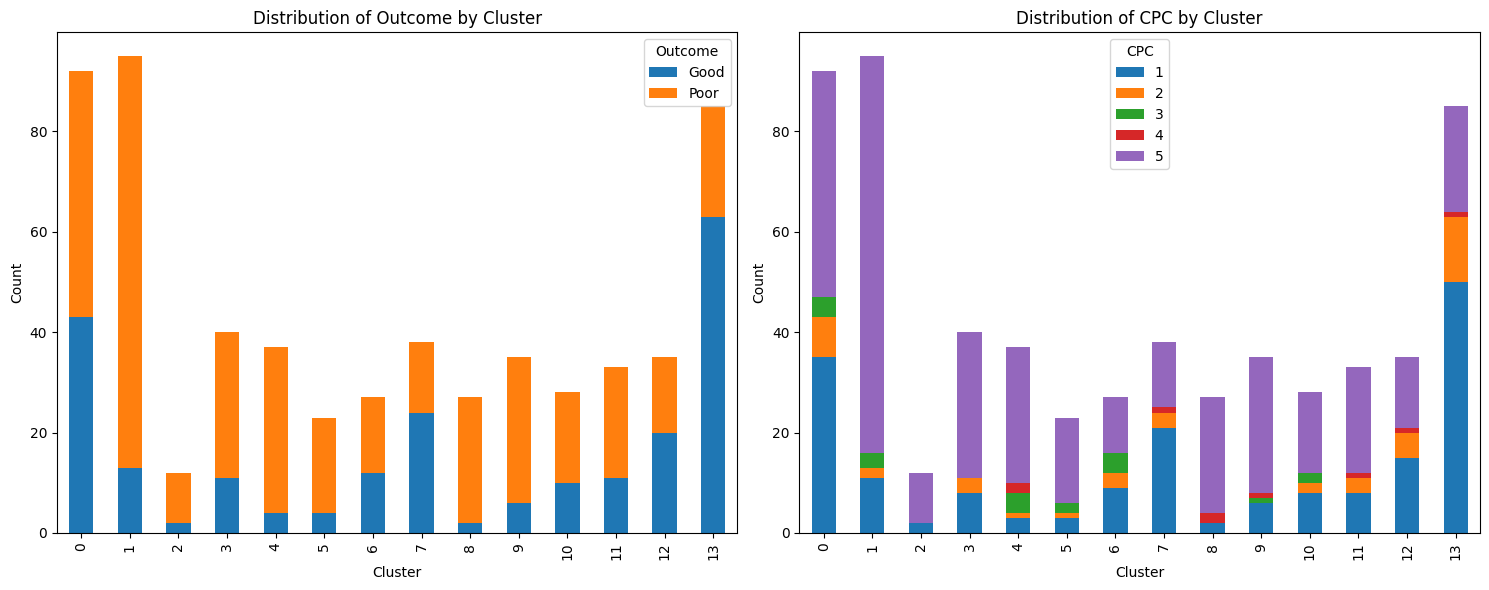

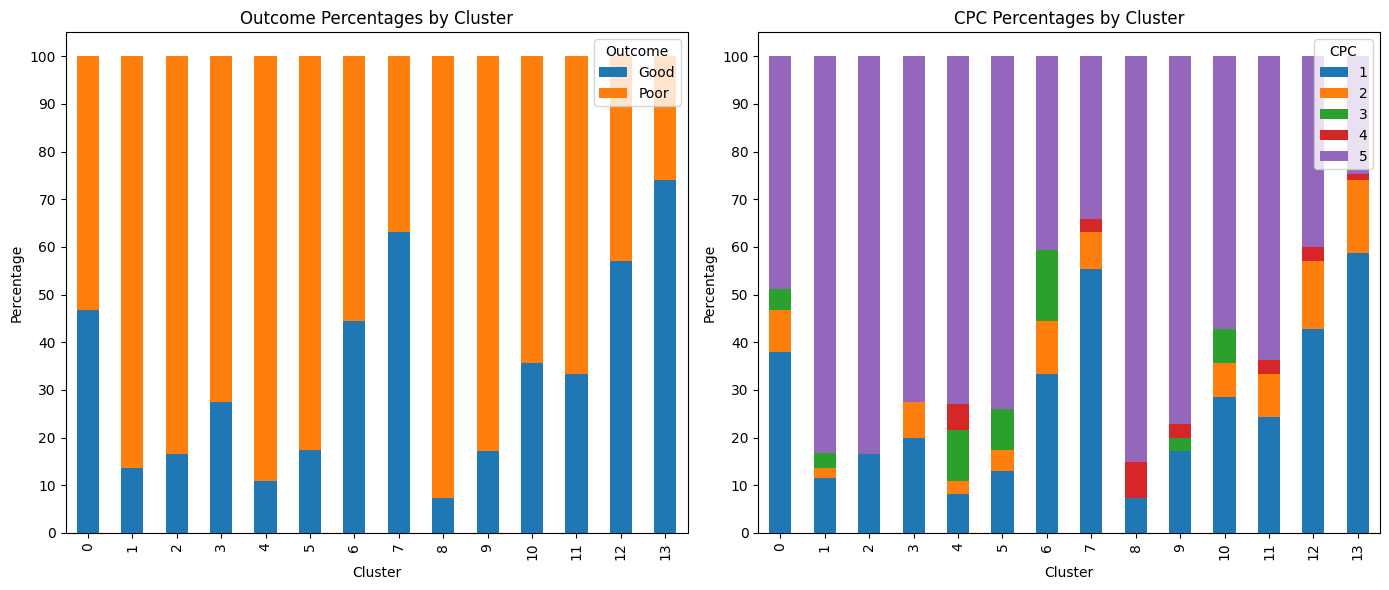

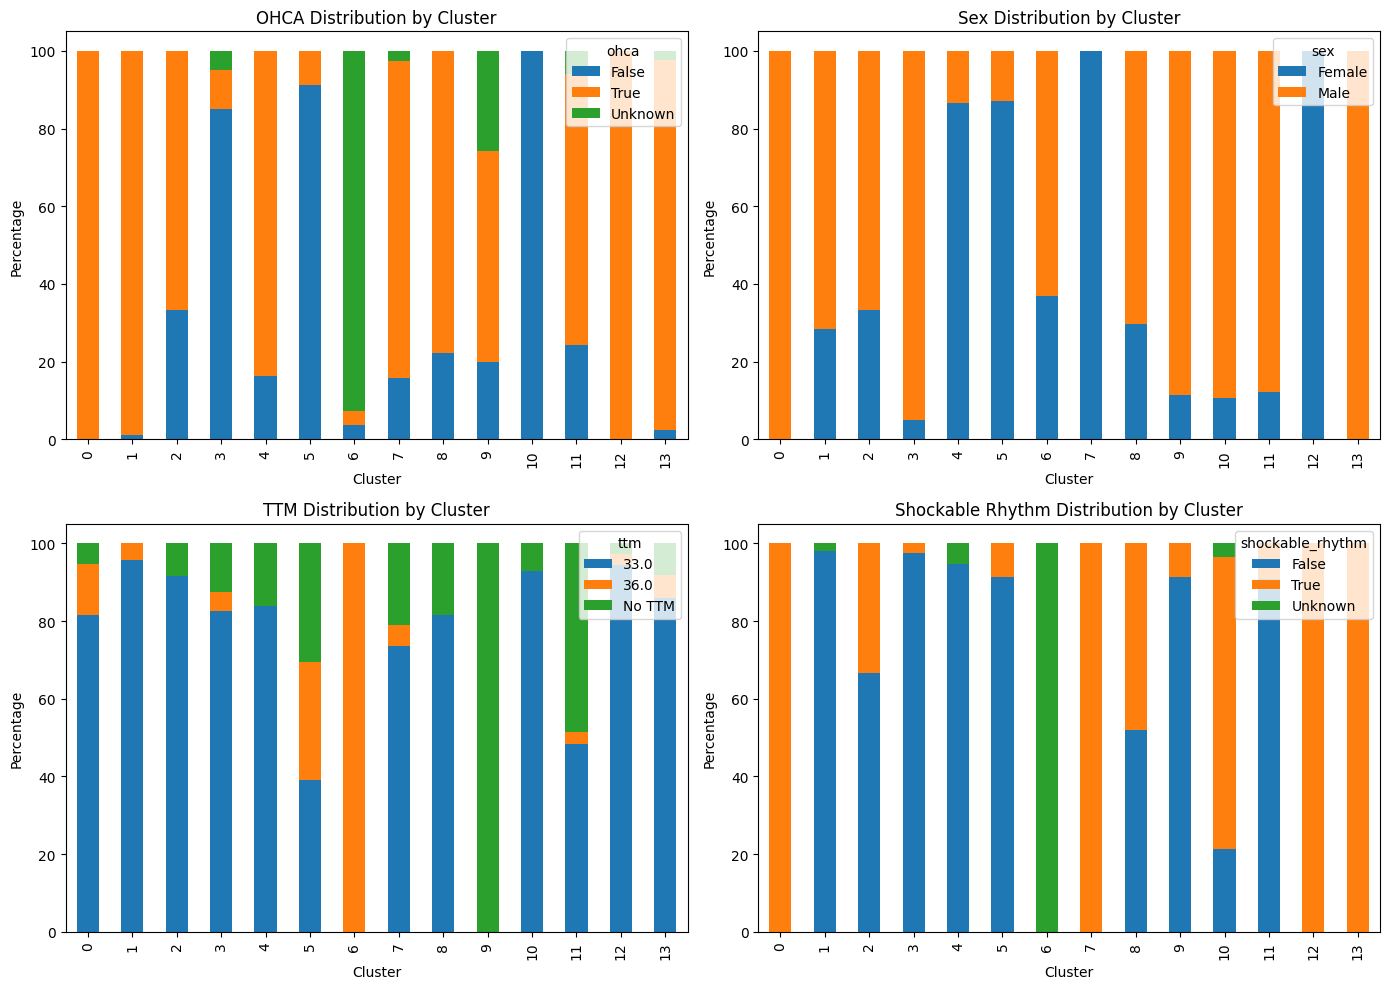

posx and posy should be finite values
posx and posy should be finite values


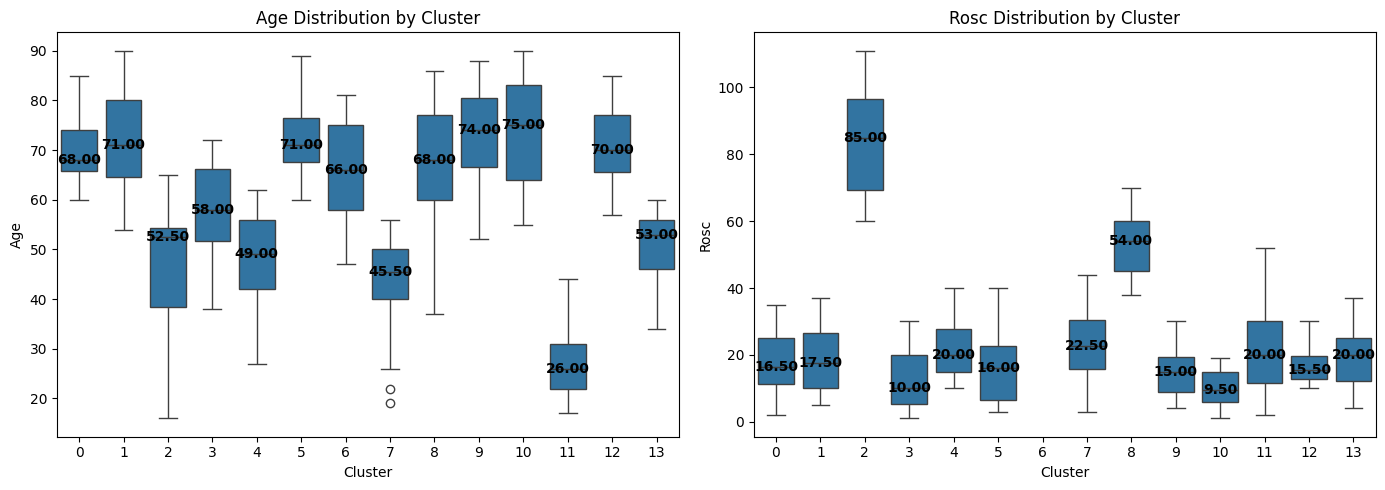

In [17]:
# Start with the distributions of CPC and Outcome
# Count the occurrences of each CPC value for each cluster
cpc_counts = original_data.groupby(['kmeans_cluster', 'cpc'], observed=True).size().unstack(fill_value=0)

# Count the occurrences of each outcome value for each cluster
outcome_counts = original_data.groupby(['kmeans_cluster', 'outcome'], observed=True).size().unstack(fill_value=0)

# Create a figure with 2 subplots for CPC and Outcome distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create the stacked bar plot for Outcome
outcome_counts.plot(kind='bar', stacked=True, ax=axes[0], label='outcome')
axes[0].set_title('Distribution of Outcome by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].legend(title='Outcome')

# Create the stacked bar plot for CPC
cpc_counts.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Distribution of CPC by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].legend(title='CPC')

plt.tight_layout()
plt.show()

# Calculate and plot Outcome percentages by cluster
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
# Calculate the CPC percentages by cluster
cpc_percentages = cpc_counts.div(cpc_counts.sum(axis=1), axis=0) * 100

# Create a figure with two subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Outcome percentages with Good outcome on bottom and Poor outcome on top
outcome_percentages[['Good', 'Poor']].plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Outcome Percentages by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Outcome')
axes[0].set_yticks(range(0, 101, 10))

# Plot CPC percentages with stacked bars
cpc_percentages.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('CPC Percentages by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='CPC')
axes[1].set_yticks(range(0, 101, 10))

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Define categorical features and their titles for the remaining plots
categorical_features_list = [
    ('ohca', 'OHCA Distribution by Cluster'),
    ('sex', 'Sex Distribution by Cluster'),
    ('ttm', 'TTM Distribution by Cluster'),
    ('shockable_rhythm', 'Shockable Rhythm Distribution by Cluster')
]

# Set up a 2x2 grid for 4 categorical features
num_features = len(categorical_features_list)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for 4 plots
axes = axes.flatten()  # Flatten for easy iteration

# Loop through each categorical feature and create a stacked bar plot with percentages
for ax, (feature, title) in zip(axes, categorical_features_list):
    # Count occurrences for each category in the feature by cluster
    feature_counts = original_data.groupby(['kmeans_cluster', feature], observed=True).size().unstack(fill_value=0)
    
    # Convert counts to percentages by dividing by the row sums
    feature_percentages = feature_counts.div(feature_counts.sum(axis=1), axis=0) * 100
    
    # Plot stacked bar chart with percentages
    feature_percentages.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Percentage')
    ax.legend(title=feature, loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Numeric features to plot
numeric_features = ['age', 'rosc']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loop through numeric features and create a box plot for each
for ax, feature in zip(axes, numeric_features):
    # Create the box plot
    sns.boxplot(x='kmeans_cluster', y=feature, data=original_data, ax=ax)
    ax.set_title(f'{feature.capitalize()} Distribution by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature.capitalize())
    
    # Calculate and annotate median values
    medians = original_data.groupby('kmeans_cluster')[feature].median()
    for cluster in medians.index:
        median_val = medians[cluster]
        ax.text(cluster, median_val, f'{median_val:.2f}', 
                ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

### Clustering Result Analysis

The stacked bar plots provide insights into the distribution of outcomes (Good vs. Poor) and CPC (Cerebral Performance Category) scores across different clusters. This visualization can help identify patterns in patient outcomes and neurological performance within each cluster. We are now looking for clusters that have an above average performance and neurological result.

---

#### Outcome Percentages by Cluster
- **Cluster 0**: Shows a mix of Good (blue) and Poor (orange) outcomes, with around 60% good outcomes, indicating a relatively balanced prognosis for this group, which is much higher than for most other clusters.
- **Clusters 1-3**: These clusters have a very high percentage of Poor outcomes, suggesting that they represent patients with worse prognoses and higher associated risks.
- **Cluster 4**: Has a more balanced distribution, with approximately 50% Good and 50% Poor outcomes, indicating a mixed-risk group.
- **Clusters 5, 6, 8**: These clusters are dominated by Bad outcomes, especially Cluster 8, which has nearly all Bad outcomes.
- **Cluster 7**: Has a more balanced distribution of almost 50:50 like **Cluster 4**.

#### CPC Percentages by Cluster
- **Cluster 0**: Shows a substantial proportion of CPC score 1 (blue), but also includes a significant amount of CPC score 5 (purple), indicating a range of neurological outcomes within this cluster.
- **Clusters 1-3**: Predominantly have higher CPC scores, especially CPC score 5 (purple), which is indicative of poorer neurological function or outcomes in these groups. Clusters 1 and 2 have minimal lower CPC scores.
- **Cluster 4**: Shows a similar distribution as **Cluster 0** with a few less CPC score 1 and shifted more towards the higher end of the CPP scale.
- **Clusters 5-8**: Display a broader distribution of CPC scores, with higher concentrations of CPC scores 1-3, suggesting moderate neurological outcomes across these clusters.

---
#### Analysis of the resulting clusters
- **Cluster 0**: Contains the highest proportion of patients with out-of-hospital cardiac arrest, around 90%. This cluster includes only male patients, with nearly 90% receiving TTM at 33°C, some at 36°C, and only a small percentage with no TTM. All patients in this cluster had an initial shockable rhythm. The median age is 64 years, placing it on the younger side among higher-age clusters. The median ROSC time is approximately 16 minutes, positioning it around the middle of clusters with shorter ROSC times.

- **Cluster 4**: Comprises about 80% out-of-hospital cardiac arrests and 20% in-hospital cardiac arrests, consisting only of female patients. Around 80% received TTM at 33°C, a few received TTM at 36°C, and about 15% did not receive TTM. Approximately 70% of the patients had a shockable rhythm. The median age is slightly under 47.5, making it one of the younger clusters. The median ROSC time is around 20 minutes, which is slightly above the median for clusters with shorter ROSC times.

- **Cluster 7**: Primarily has unknown cardiac arrest locations and unknown initial ECG rhythms. All patients in this cluster received TTM at 36°C, and around 35% of the patients were female. The median age is 65.5 years, while the average ROSC time is unknown for these patients.
---

### Overall Insights
- **High-Risk Clusters**: Clusters 0,4, and 7 have a higher proportion of better outcomes compared to the other clusters, with **cluster 0** representing the best results.
- **Few good outcome among many bads**: Many clusters are shifted towards the Bad Outcome area. It might be interesting to understand what differentiates the Good Outcomes among the many Bad Outcomes.

## Additional Clustering Analysis

### **With no TTM - 9 clusters**
Better outcome: clusters 0 and 4
Worse outcome: clusters 1,2,8,9

**Observation:** 
In all clusters, whether associated with better or worse outcomes, most patients are treated with TTM 33. However, in clusters with worse outcomes, a higher proportion of patients have unshockable rhythms.

**Conclusion:** Patients with unshockable rhythms do not appear to benefit from TTM 33.

### **Without no TTM - 13 clusters**
Better outcome: clusters 4,9,13
Worse outcome: clusters 5,8,10,11

**Observation:** 
Most clusters, regardless of outcome, predominantly receive TTM 33. However, in clusters with worse outcomes, patients tend to have unshockable rhythms. 
Additionally, in cluster 8, there is an almost equal distribution of shockable and unshockable rhythms treated with TTM 33, which would be expected to result in a higher proportion of patients with better outcomes—but this is not the case. This may be influenced by a longer ROSC time in this group.

**Conclusion:** Patients with unshockable rhythms do not benefit from TTM 33. Patients with shockable rhythms who take longer to achieve ROSC also do not appear to benefit from TTM 33.